In [ ]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import SeparableConv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import cv2
from tqdm import tqdm

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

import pickle

In [ ]:
%%capture
!pip install wandb==0.10.17
!wandb login --relogin

In [ ]:
import wandb
wandb.init(project="emotions", name="run_60")

wandb: Currently logged in as: alessandroptsn (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
!git clone https://github.com/AlessandroPTSN/fer_2013

Cloning into 'fer_2013'...
remote: Enumerating objects: 33412, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 33412 (delta 0), reused 3 (delta 0), pack-reused 33409
Receiving objects: 100% (33412/33412), 51.13 MiB | 17.27 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Checking out files: 100% (35342/35342), done.


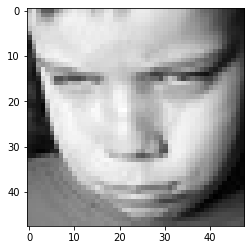

In [ ]:
DATADIR = "fer_2013/all/"

CATEGORIES = ["angry","fear","happy","neutral","sad","surprise"]

for category in CATEGORIES:  
    path = os.path.join(DATADIR,category)  # create path 
    for img in os.listdir(path):  # iterate over each image 
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

In [ ]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category)  # create path 
        class_num = CATEGORIES.index(category)  # get the classification  

        for img in tqdm(os.listdir(path)):  # iterate over each image 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
create_training_data()

print(len(training_data))

import random
IMG_SIZE = 48
random.shuffle(training_data)

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
#classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
#emotions = {0:'angry',
#            1:'disgust',
#            2:'fear',
#            3:'happy',
#            4:'neutral',
#            5:'sad',
#            6:'surprise'}
#y = [emotions[int] for int in y]
print(y)

training_data = []

def create_training_data():
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category)  # create path 
        class_num = CATEGORIES.index(category)  # get the classification  

        for img in tqdm(os.listdir(path)):  # iterate over each image 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
create_training_data()

print(len(training_data))

100%|██████████| 4002/4002 [00:00<00:00, 19883.16it/s]


0
[]


100%|██████████| 4002/4002 [00:00<00:00, 20819.79it/s]

34818


In [ ]:
import random
IMG_SIZE = 48
random.shuffle(training_data)

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
#classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
#emotions = {0:'angry',
#            1:'disgust',
#            2:'fear',
#            3:'happy',
#            4:'neutral',
#            5:'sad',
#            6:'surprise'}
#y = [emotions[int] for int in y]
print(y)

[0, 2, 5, 1, 2, 1, 4, 3, 3, 2, 4, 4, 1, 2, 3, 1, 5, 2, 1, 0, 0, 2, 4, 2, 0, 3, 4, 3, 2, 2, 5, 1, 1, 2, 3, 1, 4, 1, 5, 4, 0, 2, 0, 3, 3, 2, 4, 2, 0, 0, 0, 2, 1, 3, 1, 0, 0, 2, 3, 5, 2, 2, 1, 2, 3, 4, 2, 4, 3, 4, 3, 0, 4, 2, 0, 3, 1, 4, 1, 1, 3, 1, 2, 3, 2, 4, 2, 0, 2, 0, 4, 2, 3, 5, 2, 2, 5, 5, 1, 0, 1, 2, 2, 4, 0, 4, 0, 3, 1, 4, 2, 1, 1, 2, 0, 2, 1, 2, 4, 3, 4, 1, 1, 1, 4, 4, 5, 2, 5, 1, 2, 2, 3, 4, 2, 2, 3, 1, 2, 0, 2, 0, 1, 3, 2, 1, 4, 0, 4, 1, 0, 4, 2, 5, 2, 1, 1, 4, 1, 5, 5, 3, 0, 2, 3, 3, 4, 1, 4, 0, 4, 4, 2, 4, 0, 2, 3, 4, 1, 2, 3, 1, 2, 1, 2, 2, 2, 1, 1, 4, 4, 3, 0, 4, 3, 4, 5, 4, 3, 5, 4, 2, 0, 0, 3, 2, 1, 4, 0, 2, 5, 1, 3, 1, 1, 4, 4, 4, 3, 2, 1, 2, 2, 0, 4, 4, 3, 3, 1, 4, 1, 0, 4, 4, 1, 0, 3, 0, 3, 1, 4, 4, 3, 5, 3, 4, 0, 4, 3, 1, 0, 2, 3, 5, 4, 2, 2, 5, 5, 2, 3, 4, 4, 2, 1, 1, 3, 2, 2, 5, 3, 1, 0, 1, 2, 1, 4, 3, 4, 4, 4, 2, 5, 5, 1, 3, 2, 1, 5, 1, 5, 4, 3, 1, 3, 1, 4, 1, 4, 1, 4, 2, 4, 5, 2, 1, 4, 2, 4, 3, 0, 4, 5, 1, 2, 5, 0, 3, 1, 5, 3, 2, 0, 3, 0, 3, 0, 4, 5, 2, 1, 4, 2, 

In [ ]:
import pickle
print(y)
#data_string = pickle.dumps(X)
#print('PICKLE:', data_string )
#print('BEFORE: ', X)

with open('X.pickle.pkl', 'wb') as pickle_out:
     pickle.dump(X,pickle_out)
with open('X.pickle.pkl', 'rb') as pickle_in:
     XX = pickle.load(pickle_in)


with open('y.pickle.pkl', 'wb') as pickle_out:
     pickle.dump(y,pickle_out)
print(pickle_out)
with open('y.pickle.pkl', 'rb') as pickle_in:
     yy = pickle.load(pickle_in)
print(yy)


[0, 2, 5, 1, 2, 1, 4, 3, 3, 2, 4, 4, 1, 2, 3, 1, 5, 2, 1, 0, 0, 2, 4, 2, 0, 3, 4, 3, 2, 2, 5, 1, 1, 2, 3, 1, 4, 1, 5, 4, 0, 2, 0, 3, 3, 2, 4, 2, 0, 0, 0, 2, 1, 3, 1, 0, 0, 2, 3, 5, 2, 2, 1, 2, 3, 4, 2, 4, 3, 4, 3, 0, 4, 2, 0, 3, 1, 4, 1, 1, 3, 1, 2, 3, 2, 4, 2, 0, 2, 0, 4, 2, 3, 5, 2, 2, 5, 5, 1, 0, 1, 2, 2, 4, 0, 4, 0, 3, 1, 4, 2, 1, 1, 2, 0, 2, 1, 2, 4, 3, 4, 1, 1, 1, 4, 4, 5, 2, 5, 1, 2, 2, 3, 4, 2, 2, 3, 1, 2, 0, 2, 0, 1, 3, 2, 1, 4, 0, 4, 1, 0, 4, 2, 5, 2, 1, 1, 4, 1, 5, 5, 3, 0, 2, 3, 3, 4, 1, 4, 0, 4, 4, 2, 4, 0, 2, 3, 4, 1, 2, 3, 1, 2, 1, 2, 2, 2, 1, 1, 4, 4, 3, 0, 4, 3, 4, 5, 4, 3, 5, 4, 2, 0, 0, 3, 2, 1, 4, 0, 2, 5, 1, 3, 1, 1, 4, 4, 4, 3, 2, 1, 2, 2, 0, 4, 4, 3, 3, 1, 4, 1, 0, 4, 4, 1, 0, 3, 0, 3, 1, 4, 4, 3, 5, 3, 4, 0, 4, 3, 1, 0, 2, 3, 5, 4, 2, 2, 5, 5, 2, 3, 4, 4, 2, 1, 1, 3, 2, 2, 5, 3, 1, 0, 1, 2, 1, 4, 3, 4, 4, 4, 2, 5, 5, 1, 3, 2, 1, 5, 1, 5, 4, 3, 1, 3, 1, 4, 1, 4, 1, 4, 2, 4, 5, 2, 1, 4, 2, 4, 3, 0, 4, 5, 1, 2, 5, 0, 3, 1, 5, 3, 2, 0, 3, 0, 3, 0, 4, 5, 2, 1, 4, 2, 

In [ ]:
import time
import datetime
import pytz
from sklearn.model_selection import train_test_split

class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_begin(self, batch, logs=None):
    self.begins = time.time()
    print('Training: begins at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%a, %d %b %Y %H:%M:%S")))

  def on_train_end(self, logs=None):
    print('Training: ends at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%a, %d %b %Y %H:%M:%S")))
    print('Duration: {:.2f} seconds'.format(time.time() - self.begins))   

X_train, X_test, y_train, y_test = train_test_split(
    XX, yy, test_size=0.01, shuffle=True
    )

# Standardize the dataset
X_train = X_train/255
X_test = X_test/255

# Standardize the dataset
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
import numpy as np
import math
import collections
def get_class_weights(y):
    counter = collections.Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

labels_dict = {0: 4953, 1: 5121, 2: 8989, 3: 6198, 4: 6077, 5: 4002}
print(get_class_weights(labels_dict))
weights = get_class_weights(labels_dict)

{0: 1.8148596810014133, 1: 1.7553212263229838, 2: 1.0, 3: 1.4503065505001613, 4: 1.4791838077999013, 5: 2.2461269365317342}


In [ ]:
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(6, activation='softmax'))


adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


model.compile(
      optimizer=adam_optimizer,
      loss=tf.keras.losses.sparse_categorical_crossentropy,
      metrics=['accuracy']
)

In [ ]:
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    class_weight=weights,
                    epochs=50,
                    validation_data=(X_test,y_test),
                    callbacks=[MyCustomCallback()],
                    verbose=1)

Training: begins at Fri, 22 Jul 2022 14:23:04
Epoch 1/50
539/539 [==============================] - 19s 33ms/step - loss: 10.2477 - accuracy: 0.2164 - val_loss: 9.0635 - val_accuracy: 0.1576
Epoch 2/50
539/539 [==============================] - 18s 33ms/step - loss: 9.0929 - accuracy: 0.2622 - val_loss: 7.4291 - val_accuracy: 0.3324
Epoch 3/50
539/539 [==============================] - 18s 32ms/step - loss: 7.9848 - accuracy: 0.3138 - val_loss: 6.4123 - val_accuracy: 0.3868
Epoch 4/50
539/539 [==============================] - 17s 32ms/step - loss: 6.8981 - accuracy: 0.3650 - val_loss: 5.6204 - val_accuracy: 0.3209
Epoch 5/50
539/539 [==============================] - 17s 32ms/step - loss: 5.9416 - accuracy: 0.4029 - val_loss: 4.7333 - val_accuracy: 0.4499
Epoch 6/50
539/539 [==============================] - 17s 32ms/step - loss: 5.1201 - accuracy: 0.4385 - val_loss: 3.9232 - val_accuracy: 0.4900
Epoch 7/50
539/539 [==============================] - 18s 32ms/step - loss: 4.4444 - accu

In [ ]:
model.save("model_emotions.h5")
wandb.init()
# Save a model file manually from the current directory:
wandb.save('model_emotions.h5')

wandb: wandb version 0.12.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


['/content/wandb/run-20220722_174138-2iaz2rva/files/model_emotions.h5']

In [ ]:
best_model = wandb.restore('model_emotions.h5', run_path="alessandroptsn/uncategorized/2iaz2rva")
modelwb = tf.keras.models.load_model(best_model.name)

In [ ]:
print(modelwb.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 128)      

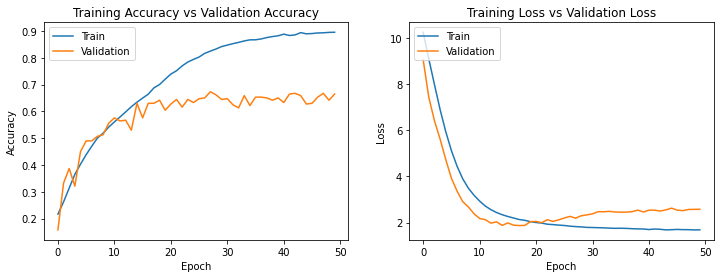

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
loss, acc = model.evaluate(x=X_train,y=y_train, batch_size=32)
print('Train loss: %.4f - acc: %.4f' % (loss, acc))

loss_, acc_ = model.evaluate(x=X_test,y=y_test, batch_size=32)
print('Test loss: %.4f - acc: %.4f' % (loss_, acc_))

1078/1078 [==============================] - 7s 7ms/step - loss: 1.3049 - accuracy: 0.9854
Train loss: 1.3049 - acc: 0.9854
11/11 [==============================] - 0s 9ms/step - loss: 2.5730 - accuracy: 0.6648
Test loss: 2.5730 - acc: 0.6648


Confusion matrix, without normalization
[[34  4  4  8  3  2]
 [ 5 25  1  4 10  1]
 [ 2  4 66  5  5  4]
 [ 3  5  1 53 16  2]
 [ 6  8  1  9 28  0]
 [ 0  4  0  0  0 26]]


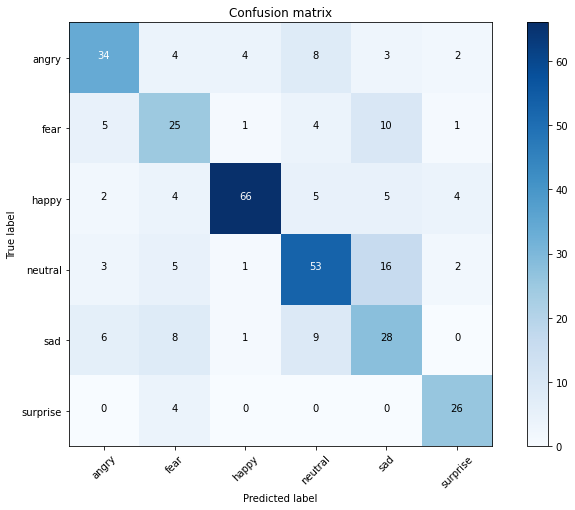

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
plt.rcParams['figure.figsize'] = [10,7]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = modelwb.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, CATEGORIES)


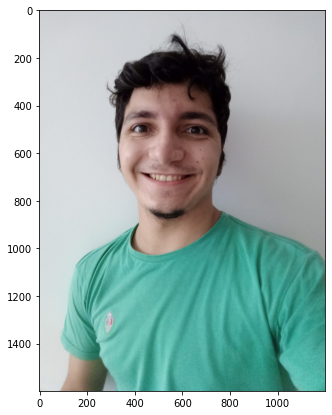

In [ ]:
ft=cv2.imread('photo.jpeg')
face_cascade = cv2.CascadeClassifier("fer_2013/haarcascade_frontalface_default.xml")
foto_=cv2.cvtColor(ft, cv2.COLOR_BGR2RGB)
foto=cv2.cvtColor(ft, cv2.COLOR_BGR2RGB)
faces = face_cascade.detectMultiScale(foto, 1.3, 3)
for (x,y,w,h) in faces:
       cv2.rectangle(foto, (x,y), (x+w, y+h), (0,0,255), 2)
       color = foto[y:y+h, x:x+w]
color=cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
if color[1,1,0] == 255:
    color=cv2.resize(color,(48,48))
    cv2.imwrite('photo_.jpg',color)

plt.imshow(foto_)

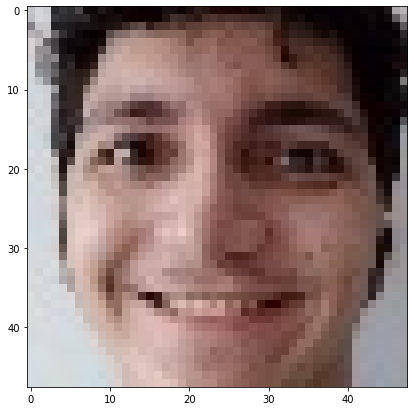

In [ ]:
fts=cv2.imread('photo_.jpg')
foto_s=cv2.cvtColor(fts, cv2.COLOR_BGR2RGB)

plt.imshow(foto_s);

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform


def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')
   np_image = transform.resize(np_image, (48, 48, 1))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

imagee = load('photo_.jpg')
prediction = np.around(modelwb.predict(imagee), decimals=2)

if str(prediction.argmax()) == '0':
  print("Angry")
if str(prediction.argmax()) == '1':
  print("Fear")
if str(prediction.argmax()) == '2':
  print("Happy")       
if str(prediction.argmax()) == '3':
  print("Neutral") 
if str(prediction.argmax()) == '4':
  print("Sad")
if str(prediction.argmax()) == '5':
  print("Surprise")


Happy
